In [1]:
import torch 
import numpy as np
from utils import DataManager, dataset_sizes, collect_training_data, compute_statistics, load_model
from probes import learn_truth_directions, BlackWhiteLRProbe, learn_bw_direction
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.metrics import roc_auc_score

In [2]:
# hyperparameters
model_family = 'Llama3' # options are 'Llama3', 'Llama2', 'Gemma', 'Gemma2' or 'Mistral'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations

# define datasets used for training
# the ordering [affirmative_dataset1, negated_dataset1, affirmative_dataset2, negated_dataset2, ...] is required by some functions
train_sets = ['colleague', 'friends', 'lawyer', 'police', "real_estate_agent", "soccer", "teacher"]
train_sets = ["b_w_lies/" + val for val in train_sets]
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 
print(train_set_sizes)

{'b_w_lies/colleague': 150, 'b_w_lies/friends': 122, 'b_w_lies/lawyer': 148, 'b_w_lies/police': 127, 'b_w_lies/real_estate_agent': 218, 'b_w_lies/soccer': 132, 'b_w_lies/teacher': 127}


## Separation between black and white statements

In [5]:
# find the layer with the largest separation between true and false statements
# you need to have stored the activations in layers 1-27 for all four datasets to run this cell
layers = np.arange(1, 32, 1)
datasets_separation = ['colleague', 'friends', 'lawyer', 'police']
datasets_separation = ["b_w_lies/" + val for val in datasets_separation]
for dataset in datasets_separation:
    between_class_variances = []
    within_class_variances = []
    for layer_nr in layers:
        dm = DataManager() 
        dm.add_dataset(dataset, model_family, model_size, model_type,
                        layer_nr, split=None, center=False, device='cpu')
        acts, labels = dm.data[dataset]
        # Calculate means for each class
        false_stmnt_ids = labels == 0
        true_stmnt_ids = labels == 1

        false_acts = acts[false_stmnt_ids]
        true_acts = acts[true_stmnt_ids]

        mean_false = false_acts.mean(dim=0)
        mean_true = true_acts.mean(dim=0)

        # Calculate within-class variance
        within_class_variance_false = false_acts.var(dim=0).mean()
        within_class_variance_true = true_acts.var(dim=0).mean()
        within_class_variances.append((within_class_variance_false + within_class_variance_true).item() / 2)

        # Calculate between-class variance
        overall_mean = acts.mean(dim=0)
        between_class_variances.append(((mean_false - overall_mean).pow(2) 
                                        + (mean_true - overall_mean).pow(2)).mean().item() / 2)

    plt.plot(layers, np.array(between_class_variances) / np.array(within_class_variances), label=dataset.split('/')[-1], linewidth=3)
plt.legend(fontsize=16)
plt.ylabel('Between class variance /\nwithin-class variance', fontsize=18)
plt.xlabel('Layer', fontsize=18)
plt.title('Separation between white and black\nlies across layers', fontsize=19)
plt.grid(True)

KeyboardInterrupt: 

### Classification accuracies

In [ ]:
import numpy as np
import torch
from sklearn.linear_model import LogisticRegressionCV

# Ensure train_sets, etc. are defined

print("\n=== Training CENTERED Probe with Universal Mean ===")

# 1. Collect RAW Data
# We need the raw data first to calculate our own mean
_, all_acts_raw, all_labels, _ = collect_training_data(
    train_sets, train_set_sizes, model_family, model_size, model_type, layer
)

# 2. Calculate and Subtract Mean
# This vector represents the "center of mass" of typical LLM activations
universal_mean = torch.mean(all_acts_raw, dim=0)
X_centered = (all_acts_raw - universal_mean).numpy()
y = all_labels.numpy()

In [4]:
# ==============================================
# FINAL STEP: Train Master Probe on ALL Data
# ==============================================
print("\n=== Training Final Probe on ALL Datasets ===")

# Collect data from ALL train_sets (no hold-outs)
all_acts_centered, all_acts, all_labels, _ = collect_training_data(
    train_sets, train_set_sizes, model_family, model_size, model_type, layer
)

# Fit the final LR model
LR_final = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
LR_final.fit(all_acts.numpy(), all_labels.numpy())

# Extract the direction vector
d_final = torch.from_numpy(LR_final.coef_[0]).float()

# Save to file
save_path = 'black_white_classification.pt'
torch.save(d_final, save_path)
print(f"Successfully saved probe direction to {save_path}")
print(f"Probe shape: {d_final.shape}")


=== Training Final Probe on ALL Datasets ===
Successfully saved probe direction to black_white_classification.pt
Probe shape: torch.Size([4096])


### Test accuract of LR

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


Probe loaded. Shape: torch.Size([4096]), Dtype: torch.float32
Loaded 97 rows from datasets/lie_statements/black_lies/colleagues.csv
Loaded 97 rows from datasets/lie_statements/black_lies/police.csv
Loaded 97 rows from datasets/lie_statements/black_lies/sales.csv
Loaded 99 rows from datasets/lie_statements/black_lies/teachers.csv
Loaded 100 rows from datasets/lie_statements/white_lies/colleagues.csv
Loaded 109 rows from datasets/lie_statements/white_lies/friendship.csv
Loaded 162 rows from datasets/lie_statements/white_lies/parents.csv
Loaded 96 rows from datasets/lie_statements/white_lies/teachers.csv

Running inference on 857 statements...
Processed 0/857...
Processed 50/857...
Processed 100/857...
Processed 150/857...
Processed 200/857...
Processed 250/857...
Processed 300/857...
Processed 350/857...
Processed 400/857...
Processed 450/857...
Processed 500/857...
Processed 550/857...
Processed 600/857...
Processed 650/857...
Processed 700/857...
Processed 750/857...
Processed 800/857.

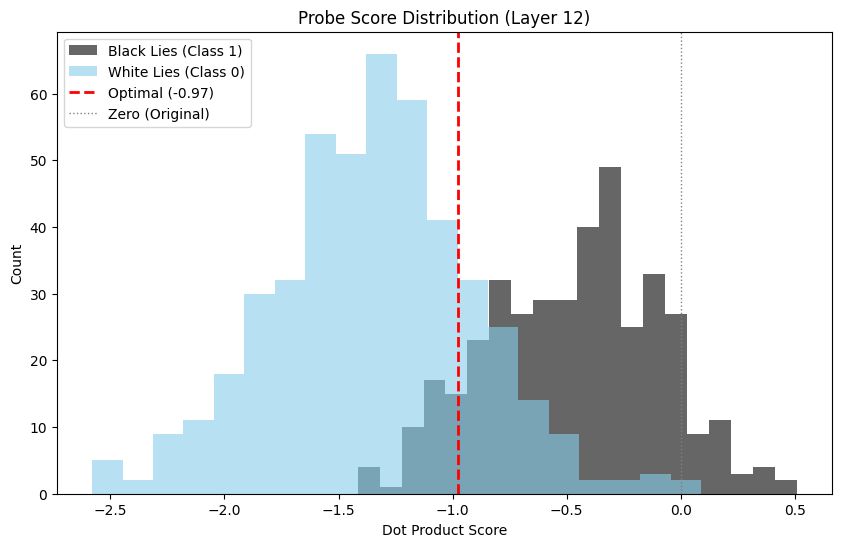


=== Final Accuracy with Threshold -0.9743 ===
Black Lies Accuracy: 352/390 (90.26%)
White Lies Accuracy: 379/467 (81.16%)
Overall Accuracy:    85.30%


: 

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, accuracy_score
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1. Configuration
# =================
device = "cuda" if torch.cuda.is_available() else "cpu"
probe_path = 'black_white_classification.pt'
text_column = "statement" # Ensure your CSVs have this column header

# UPDATED PATHS
black_lie_files = [
    "colleagues",
    "police",
    "sales",
    "teachers"
]

black_lie_files = ["datasets/lie_statements/black_lies/" + file + ".csv" for file in black_lie_files]

white_lie_files = [
    "colleagues",
    "friendship",
    "parents",
    "teachers"
    #"neutral"
]

white_lie_files = ["datasets/lie_statements/white_lies/" + file + ".csv" for file in white_lie_files]

# 2. Helper Functions
# ===================
def load_datasets_from_list(file_list, label_int, text_col):
    data_entries = []
    for file_path in file_list:
        if not os.path.exists(file_path): 
            print(f"Warning: File not found: {file_path}")
            continue
        try:
            df = pd.read_csv(file_path)
            # Strip whitespace from column names just in case
            df.columns = [c.strip() for c in df.columns]
            
            if text_col in df.columns:
                for text in df[text_col].dropna():
                    data_entries.append((str(text), label_int))
                print(f"Loaded {len(df)} rows from {file_path}")
            else:
                print(f"Error: Column '{text_col}' not found in {file_path}. Found: {df.columns.tolist()}")
        except Exception as e: 
            print(f"Error reading {file_path}: {e}")
    return data_entries

# Ensure model/tokenizer are loaded
# tokenizer, model = load_model(...)
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.bfloat16, device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token or tokenizer.pad_token
tokenizer.padding_side = "left"
model.generation_config.pad_token_id = tokenizer.eos_token_id
model.eval() 

def get_live_activation(text, model, tokenizer, layer_idx, device):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    return outputs.hidden_states[layer_idx][0, -1, :]

# 3. Collect Scores
# =================
# Load Probe
d_probe = torch.load(probe_path, map_location=device)
d_probe = d_probe.to(device)
print(f"Probe loaded. Shape: {d_probe.shape}, Dtype: {d_probe.dtype}")

# Load Data
data = []
data.extend(load_datasets_from_list(black_lie_files, 1, text_column)) # Black = 1
data.extend(load_datasets_from_list(white_lie_files, 0, text_column)) # White = 0

if len(data) == 0:
    raise ValueError("No data loaded. Please check your file paths and column names.")

all_scores = []
all_labels = []

print(f"\nRunning inference on {len(data)} statements...")

for i, (text, label) in enumerate(data):
    # Get Activation
    act = get_live_activation(text, model, tokenizer, layer, device)
    
    # Fix dtype mismatch (BFloat16 vs Float32)
    act = act.to(dtype=d_probe.dtype) 
    
    # Project
    score = torch.dot(act, d_probe).item()
    
    all_scores.append(score)
    all_labels.append(label)
    
    if i % 50 == 0: print(f"Processed {i}/{len(data)}...")

# 4. Find Optimal Threshold
# =========================
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"\n=== CALIBRATION RESULTS ===")
print(f"Optimal Threshold Found: {best_thresh:.4f}")

# 5. Visualization
# ================
plt.figure(figsize=(10, 6))
scores_black = [s for s, l in zip(all_scores, all_labels) if l == 1]
scores_white = [s for s, l in zip(all_scores, all_labels) if l == 0]



plt.hist(scores_black, bins=20, alpha=0.6, label='Black Lies (Class 1)', color='black')
plt.hist(scores_white, bins=20, alpha=0.6, label='White Lies (Class 0)', color='skyblue')
plt.axvline(best_thresh, color='red', linestyle='dashed', linewidth=2, label=f'Optimal ({best_thresh:.2f})')
plt.axvline(0, color='gray', linestyle='dotted', linewidth=1, label='Zero (Original)')

plt.title(f'Probe Score Distribution (Layer {layer})')
plt.xlabel('Dot Product Score')
plt.ylabel('Count')
plt.legend()
plt.show()

# 6. Recalculate Accuracy
# =======================
predictions = [1 if s > best_thresh else 0 for s in all_scores]

black_correct = sum([1 for p, l in zip(predictions, all_labels) if p == l and l == 1])
black_total = sum([1 for l in all_labels if l == 1])
white_correct = sum([1 for p, l in zip(predictions, all_labels) if p == l and l == 0])
white_total = sum([1 for l in all_labels if l == 0])

print(f"\n=== Final Accuracy with Threshold {best_thresh:.4f} ===")
print(f"Black Lies Accuracy: {black_correct}/{black_total} ({black_correct/black_total*100:.2f}%)")
print(f"White Lies Accuracy: {white_correct}/{white_total} ({white_correct/white_total*100:.2f}%)")
print(f"Overall Accuracy:    {accuracy_score(all_labels, predictions)*100:.2f}%")

In [ ]:
# Create a custom colormap from red to yellow
cmap = LinearSegmentedColormap.from_list('red_yellow', [(1, 0, 0), (1, 1, 0)], N=100)

# Single subplot
fig, ax = plt.subplots(figsize=(3, 6))
key = 'd_{LR}'

# Build Nx1 grid of values (one per dataset)
grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
im = ax.imshow(grid, vmin=0, vmax=1, cmap=cmap)

# Layout & annotations
ax.set_aspect('auto')
for i, row in enumerate(grid):
    for j, val in enumerate(row):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=13)

ax.set_yticks(range(len(train_sets)))
ax.set_yticklabels(train_sets, fontsize=13)
ax.set_xticks([])
ax.set_title(r"$d_{LR}$", fontsize=14)

# Adjust layout and add colorbar
plt.subplots_adjust(top=0.9, bottom=0.05, left=0.25, right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=13)

fig.suptitle("AUROC", fontsize=15)
plt.show()


### Learn 1d direction

In [ ]:
# --- 1) Learn single black/white direction on centered activations ---
acts_centered, _, labels_bw, _ = collect_training_data(
    train_sets, train_set_sizes, model_family, model_size, model_type, layer
)
t_bw, _ = learn_bw_direction(acts_centered, labels_bw, positive_label=1, normalize=True)



def calculate_auroc(acts, labels, t):
    if isinstance(acts, torch.Tensor):
        acts = acts.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()

    proj = t @ acts.T
    auroc = roc_auc_score(labels, proj)
    return auroc

def plot_density(ax, acts, labels, t, xlabel):
    # Convert inputs to NumPy arrays if they're PyTorch tensors
    if isinstance(acts, torch.Tensor):
        acts = acts.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()

    # Compute projections
    if t.ndim == 1:
        proj = t @ acts.T
    else:
        proj = t.reshape(1, -1) @ acts.T

    # Compute axis limits based on projected activations
    x_min, x_max = np.min(proj), np.max(proj)
    x_range = x_max - x_min
    x_padding = 0.1 * x_range  # Add 10% padding on each side
    xlim = (x_min - x_padding, x_max + x_padding)

    # Set x-axis limits
    ax.set_xlim(xlim)

    # Compute KDE for each label
    x_grid = np.linspace(xlim[0], xlim[1], 400)
    for label, color in zip([0, 1], ['indigo', 'orange']):
        data = proj[labels == label]
        kde = gaussian_kde(data)
        density = kde(x_grid)
        density /= np.trapz(density, x_grid)
        ax.plot(x_grid, density, color=color)

    # Plot scatter points
    y_scatter = np.ones(np.shape(proj)) * (-0.05)
    colors = ['indigo' if label == 0 else 'orange' for label in labels]
    ax.scatter(proj, y_scatter, c=colors, alpha=0.3, s=10)

    # Set y-axis limits to accommodate both KDE and scatter points
    y_max = ax.get_ylim()[1]
    ax.set_ylim(-0.1, y_max * 1.1)  # Extend y-axis slightly above the maximum KDE value

     # Calculate AUROC
    auroc = calculate_auroc(acts, labels, t)

    # Display AUROC in the top left corner
    ax.text(0.05, 0.95, f'AUROC: {auroc:.2f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

    # Set labels and remove ticks
    ax.set_ylabel('Frequency', fontsize=19)
    ax.set_xlabel(xlabel, fontsize=19)
    ax.set_yticks([])
    ax.set_xticks([])

    # Add a light grid
    ax.grid(True, linestyle='--', alpha=0.3)

# --- 2) Collect ALL data for visualization (balanced per dataset) ---
def collect_all_data(train_sets, train_set_sizes, model_family, model_size, model_type, layer, center=True):
    dm = DataManager()
    min_size = min(train_set_sizes.values())
    for ds in train_sets:
        split = min_size / train_set_sizes[ds]
        dm.add_dataset(ds, model_family, model_size, model_type, layer,
                       split=split, center=center, device='cpu')
    return dm.get('train')  # -> (acts, labels)

acts_all, labels_all = collect_all_data(
    train_sets, train_set_sizes, model_family, model_size, model_type, layer, center=True
)

# --- 3) Plot a single density panel along t_bw, colored by black/white ---
fig, ax = plt.subplots(figsize=(8, 4))
plot_density(ax, acts_all, labels_all, t_bw, xlabel=r"$a^T t_{BW}$")
ax.set_title("Affirmative & Negated\nStatements", fontsize=19)

# Legend for white vs black lies
handles = [
    plt.scatter([], [], c='indigo', marker='s', label='White lie (0)'),
    plt.scatter([], [], c='orange', marker='^', label='Black lie (1)'),
]
ax.legend(handles=handles, fontsize=14, loc='upper right', framealpha=0.85)

plt.tight_layout()
plt.show()





### Amount of points missclassified